In [1]:
from __future__ import unicode_literals

import json

from hazm import *


def read_file():
    documents_title = []
    documents_content = []
    documents_url = []
    with open('../Phase_1/assets/IR_data_news_12k.json', encoding='UTF-8') as f:
        data = json.load(f)
        for i in data:
            documents_title.append(data[i]["title"])
            documents_content.append(data[i]["content"])
            documents_url.append(data[i]['url'])
    return documents_url, documents_title, documents_content


docs_url, docs_title, docs_content = read_file()
normalizer = Normalizer()

In [2]:
# coding: utf8
from os import path
import codecs
from hazm.Normalizer import Normalizer
from Phase_1.src.utils import data_path

default_stop_words = path.join(data_path, 'stopwords.dat')


class StopWord:
    """ Class for remove stop words

         """

    def __init__(self, file_path=default_stop_words, normal=False):
        self.file_path = file_path
        self.normal = normal
        self.normalizer = Normalizer().normalize
        self.stop_words = self.init(file_path, normal)

    def init(self, file_path, normal):
        if not normal:
            return set(
                line.strip("\r\n") for line in codecs.open(file_path, "r", encoding="utf-8").readlines())
        else:
            return set(
                self.normalizer(line.strip("\r\n")) for line in
                codecs.open(file_path, "r", encoding="utf-8").readlines())

    def set_normalizer(self, func):
        self.normalizer = func
        self.stop_words = self.init(self.file_path, self.normal)

    def __getitem__(self, item):
        return item in self.stop_words

    def __str__(self):
        return str(self.stop_words)

    def clean(self, iterable_of_strings, return_generator=False):
        if return_generator:
            return filter(lambda item: not self[item], iterable_of_strings)
        else:
            return list(filter(lambda item: not self[item], iterable_of_strings))


In [3]:
class Document:
    def __init__(self, content, url, title):
        self.content = content
        self.url = url
        self.title = title


In [40]:
def heaps_law(dict_size, num_total_tokens, number):
    print(f'at {number}th document we seen {num_total_tokens} total tokens and dictionary size was {dict_size}')

In [64]:
from matplotlib import pyplot as plt


def preprocess_content(content):
    str_empty = ' '
    stemmer = Stemmer()
    content = normalizer.normalize(content)
    content = word_tokenize(content)
    content = StopWord(normal=False).clean(content)
    content = [stemmer.stem(word) for word in content]
    content = str_empty.join(content)
    return content


def process_positions(preprocessed_content):
    positions = {}
    for position_of_word, word in enumerate(preprocessed_content.split()):
        if word and word not in positions:
            positions[word] = []
        positions[word].append(position_of_word)
    return positions


def generate_index(positions, title):
    return {"number of occurrences in document": len(positions),
            "positions": positions,
            "title of document": title}


class PositionalIndex:
    def __init__(self, documents_url, documents_title, documents_content):
        self.Documents = [Document(documents_content[i], documents_url[i], documents_title[i]) for i in
                          range(len(documents_url))]
        self.positional_index_structure = {}
        self.url_to_information = {}
        self.build_positional_index()
        self.build_url_to_information_dict()

    def build_positional_index(self):
        num_tokens = 0
        x = []
        y = []
        for i, document in enumerate(self.Documents):
            preprocessed_content = preprocess_content(document.content)
            processed_content = process_positions(preprocessed_content)
            title_of_document = document.title
            url = document.url
            num_tokens += len(processed_content.keys())
            for word, positions in processed_content.items():
                self.add_index(word, positions, title_of_document, url)
            if i % 500 or not i or i > 2000:
                continue
            x.append(len(self.positional_index_structure.keys()))
            y.append(num_tokens)
            heaps_law(dict_size=len(self.positional_index_structure.keys()), num_total_tokens=num_tokens, number=i)
        heaps_law(dict_size=len(self.positional_index_structure.keys()), num_total_tokens=num_tokens, number=len(self.Documents))
        plt.clf()
        plt.title('With Stemming')
        plt.plot(x, y, 'g-')
        plt.show()

    def add_index(self, word, positions, title, url):
        index_to_add = generate_index(positions, title)
        if word not in self.positional_index_structure:
            self.positional_index_structure[word] = {"total occurrences": 0,
                                                     "indexes": {}}
        self.positional_index_structure[word]["total occurrences"] += index_to_add[
            "number of occurrences in document"]
        self.positional_index_structure[word]["indexes"][url] = index_to_add

    def build_url_to_information_dict(self):
        for document in self.Documents:
            self.url_to_information[document.url] = {"title": document.title,
                                                     "content": document.content}


# Heaps Law

## With Stemming

at 500th document we seen 47555 total tokens and dictionary size was 7490
at 1000th document we seen 96789 total tokens and dictionary size was 10816
at 1500th document we seen 144986 total tokens and dictionary size was 12869
at 2000th document we seen 190599 total tokens and dictionary size was 14559
at 12202th document we seen 1508103 total tokens and dictionary size was 49918


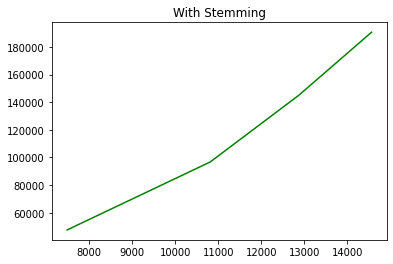

In [61]:
pos_index = PositionalIndex(documents_url=docs_url, documents_title=docs_title, documents_content=docs_content)

## Without Stemming

at 500th document we seen 49652 total tokens and dictionary size was 9701
at 1000th document we seen 101067 total tokens and dictionary size was 14433
at 1500th document we seen 151450 total tokens and dictionary size was 17455
at 2000th document we seen 199074 total tokens and dictionary size was 19870
at 12202th document we seen 1595725 total tokens and dictionary size was 72354


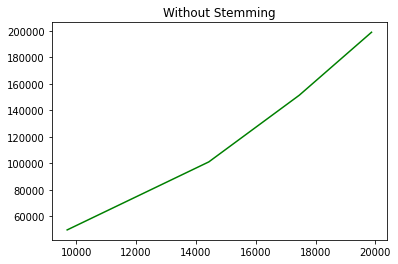

In [63]:
pos_index2 = PositionalIndex(documents_url=docs_url, documents_title=docs_title, documents_content=docs_content)

# Zipf law

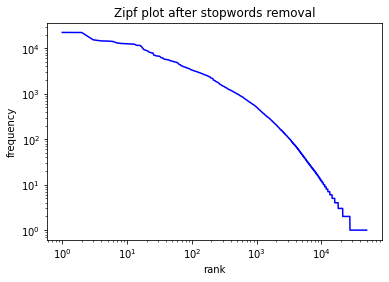

In [27]:
def zipf_law(frequencies, title):
    from matplotlib import pyplot as plt

    frequencies.sort(reverse=True)

    # enumerate the ranks and frequencies
    rf = [(r + 1, f) for r, f in enumerate(frequencies)]
    rs, fs = zip(*rf)

    plt.clf()
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('rank')
    plt.ylabel('frequency')
    plt.plot(rs, fs, 'b-')
    plt.show()


occurrences = [info['total occurrences'] for info in (pos_index.positional_index_structure.values())]
zipf_law(occurrences, 'Zipf plot after stopwords removal')


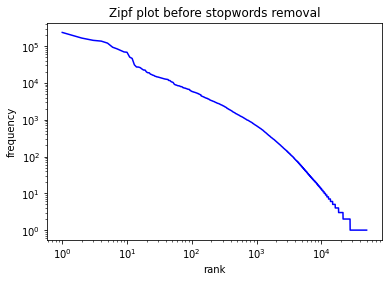

In [26]:
pos2_index = PositionalIndex(documents_url=docs_url, documents_title=docs_title, documents_content=docs_content)
occurrences = [info['total occurrences'] for info in (pos2_index.positional_index_structure.values())]
zipf_law(occurrences, 'Zipf plot before stopwords removal')

In [6]:
def docID(number, lst_urls):
    return lst_urls[number]


def position(plist):
    return plist['positions']


def pos_intersect(p1, p2, k):
    answer = {}  # answer <- ()
    len1 = len(p1)
    len2 = len(p2)
    i = j = 0
    lst_urls1 = sorted(list(p1.keys()))
    lst_urls2 = sorted(list(p2.keys()))
    while i != len1 and j != len2:
        key = docID(i, lst_urls1)
        key2 = docID(j, lst_urls2)
        if key == key2:
            l = []
            pp1 = position(p1[key])
            pp2 = position(p2[key])

            plen1 = len(pp1)
            plen2 = len(pp2)
            ii = jj = 0
            while ii != plen1:
                while jj != plen2:
                    if abs(pp1[ii] - pp2[jj]) <= k:
                        l.append(pp2[jj])
                    elif pp2[jj] > pp1[ii]:
                        break
                    jj += 1
                # l.sort()
                while l != [] and abs(l[0] - pp1[ii]) > k:
                    l.remove(l[0])
                for ps in l:
                    if key in answer:
                        # answer[key]['positions'].extend([pp1[ii], ps])
                        answer[key]['positions'].extend([max(pp1[ii], ps)])
                    else:
                        answer[key] = {'positions': [max(pp1[ii], ps)]}
                ii += 1
            i += 1
            j += 1
            if key in answer:
                answer[key]['positions'] = list(set(answer[key]['positions']))
        elif key < key2:
            i += 1
        else:
            j += 1
    return answer


def calc_string(string):
    state = False
    i = 0
    while i < len(string):
        ch = string[i]
        if ch == "\"":
            if state:
                string = string[:i] + '>' + string[i + 1:]
            else:
                string = string[:i] + '<' + string[i + 1:]
            state = 1 ^ state
        elif ch == '!':
            string = string[:i - 1] + ' _NOT_ ' + string[i + 1:]
        i += 1
    return string


def preprocess_query(query):
    query = calc_string(query)
    return preprocess_pipeline(query)


def preprocess_pipeline(query):
    str_empty = ' '
    stemmer = Stemmer()
    query = normalizer.normalize(query)
    query = word_tokenize(query)
    query = StopWord(normal=False).clean(query)
    query = [stemmer.stem(word) for word in query]
    query = str_empty.join(query)
    return query


class QueryHandler:
    def __init__(self, positional_index):
        self.positional_index = positional_index

    def answer_query(self, query):
        query = preprocess_query(query)
        not_queries = []
        and_queries = []
        empty_str = ' '
        is_not = False
        is_consecutive = False
        consecutive = []

        i = 0
        while i < len(query):
            next_occur = query.find(empty_str, i)
            substr = query[i:next_occur]
            if next_occur == -1:
                substr = query[i:]
            if substr == '_NOT_':
                is_not = True
                i = next_occur + 1
                continue
            elif is_not:
                not_queries.append(self.get_result([substr]))
                is_not = False
                i = next_occur + 1
                if next_occur == -1:
                    break
                continue
            elif substr[0] == '<':
                word = preprocess_pipeline(substr[1:])
                if word:
                    consecutive.append(word)
                i = next_occur + 1
                is_consecutive = True
                continue
            elif substr[-1] == '>':
                word = preprocess_pipeline(substr[:-1])
                if word:
                    consecutive.append(word)
                and_queries.append(self.get_result(consecutive))
                i = next_occur + 1
                consecutive.clear()
                is_consecutive = False
                if next_occur == -1:
                    break
                continue
            elif is_consecutive:
                consecutive.append(substr)
                i = next_occur + 1
                continue
            and_queries.append(self.get_result([substr]))
            i = next_occur + 1
            if next_occur == -1:
                break
        and_results = self.handle_queries(and_queries)
        not_results = self.handle_queries(not_queries)
        query_result = self.remove_by_sub_queries(and_results, not_results)
        get_score = lambda x: x['score']
        return sorted(query_result, key=get_score, reverse=True)

    def remove_by_sub_queries(self, in_results, out_results):
        answer = []
        for in_item_url in in_results:
            if in_item_url in out_results:
                continue
            index = {'title': self.positional_index.url_to_information[in_item_url]['title'],
                     'score': len(in_results[in_item_url]['positions']),
                     'url': in_item_url,
                     'content': self.positional_index.url_to_information[in_item_url]['content']}
            answer.append(index)
        return answer

    @staticmethod
    def handle_queries(queries):
        if not queries:
            return {}
        temporary_result = queries[0]
        for item_to_intersect in queries[1:]:
            if temporary_result:
                temporary_result = pos_intersect(temporary_result, item_to_intersect, 1000000)
            else:
                temporary_result = item_to_intersect
        return temporary_result

    def get_result(self, words):
        if words[0] not in self.positional_index.positional_index_structure:
            return {}
        temp_result = self.positional_index.positional_index_structure[words[0]]['indexes']
        for word in words[1:]:
            if word not in self.positional_index.positional_index_structure:
                temp_result = {}
                break
            indexes_of_word = self.positional_index.positional_index_structure[word]['indexes']
            if temp_result:
                temp_result = pos_intersect(temp_result, indexes_of_word, 1)
            else:
                temp_result = indexes_of_word
        return temp_result


query_handler = QueryHandler(positional_index=pos_index)


In [9]:
def print_results(query_string, number_to_prints=10):
    for single_result in query_handler.answer_query(query_string)[:number_to_prints]:
        print(f"score: {single_result['score']},\n"
              f"url: {single_result['url']},\n"
              f"title: {single_result['title']}\n"
              f'content: {single_result["content"]}\n*********************************************************\n\n')

# sample results


In [65]:
print_results('تحریم های آمریکا علیه ایران')

score: 137,
url: https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین,
title: توضیحات یک منبع آگاه درباره وقفه مذاکرات وین
content: 
به گزارش خبرنگار سیاسی خبرگزاری فارس، به نظر می‌رسد مذاکرات وین به روزهای آخر خود نزدیک شده است و براساس اعلام برخی منابع تا رسیدن به توافق راه زیادی باقی نمانده و تنها نیاز است آمریکا به آنچه در برجام برای برداشتن تحریم‌ها وعده داده  عمل کند و تضمین معتبری هم برای انجام این تعهدات داده شود. براساس اعلام مسئولان سیاست خارجه در کنار دریافت تضمین‌ معتبر، برداشتن همه تحریم‌ها از نکات و مطالبات اصلی ایران در مذاکرات است. اما به نظر می‌رسد آمریکا در مقابل عمل به این تعهد برجامی مقاومت می‌کند. * تحریم‌های آمریکا علیه ایران آمریکا پس از تسخیر لانه‌ جاسوسی آمریکا در تهران، «کارتر» در تاریخ 8 نوامبر 1979م. با استناد به قانون‌ «کنترل صدور تسلیحات نظامی»، کشتی حامل‌ لوازم یدکی نظامی متعلق به ایران را توقیف کرد. ارزش این لوازم 300 میلیون دلار بود. با اوج‌گیری کشمکش‌های سیاسی بر سر مسئله‌ تصرف سفارت، دولت موقت، اعلام کرد تمام دارایی

In [66]:
print_results('تحریم های آمریکا ! ایران')

score: 9,
url: https://www.farsnews.ir/news/14001108000202/خطیب-جمعه-تهران-سازمان‌-همکاری-اسلامی-در-برابر-کشتار-مردم-یمن-سکوت,
title: خطیب جمعه تهران: سازمان‌ همکاری اسلامی در برابر کشتار مردم یمن سکوت کرده است
content: 
به گزارش خبرنگار سیاسی خبرگزاری فارس، آیت‌الله سیداحمد خاتمی امام جمعه موقت تهران، امروز در خطبه‌های اول نماز جمعه که در مصلای امام خمینی (ره) اقامه شد، در ادامه سلسله مباحث سبک زندگی اظهار داشت: آیین‌نامه زندگی خدایی در قرآن کریم و در آیه 24 سوره انفال آمده است که بر اساس آن، هر آنچه را که خدا و پیامبر اکرم (ص) دستور داده‌اند، باید عمل شود. وی ادامه داد: رسالت دین فقط آبادی آخرت نیست، بلکه دین به دنبال آبادی دنیا و آخرت است؛ کسانی که بخاطر دنیا، آخرت را فراموش می‌کنند و کسانی که بخاطر آخرت، دنیای خود را فراموش می‌کنند، هیچکدام مطلوب دین نیستند. خطیب نماز جمعه تهران تصریح کرد: این نقطه، مقابل تفکرات انحرافی سکولاریزم مذهبی است که می‌گویند کار دین، فقط آبادی آخرت است و دنیا را به اهل دنیا بسپارید. خاتمی با اشاره به خداباوری و عمل صالح به عنوان ستون فقرات تفکر دینی گفت: 

In [13]:
print_results('"خبرگزاری فارس"')


score: 18,
url: https://www.farsnews.ir/news/14001122000809/خبرگزاری-فارس-۱۹-ساله-شد,
title: خبرگزاری فارس ۱۹ ساله شد
content: 
خبرگزاری فارس در ۲۲ بهمن سال ۱۳۸۱ و در شرایط غربت انقلاب در فضای رسانه‌ای کشور متولد شد و خیلی زود توانست با شعار «فارس فرزند ایران است» جایگاه خود را به عنوان پرمخاطب‌ترین خبرگزاری کشور و یکی از رسانه‌های اثرگذار جریان مقاومت تثبیت کند. فارس تلاش می‌کند گامی در جهت روشن کردن حقایق داشته باشد و معتقد است که سرانجام «حقیقت روشن می‌شود». بنابراین هویت بصری خود را مبتنی بر این شعار و بر مبنای عناصر کلیدی اعتماد، انقلاب و امید و مبتنی بر ماموریت‌های جدید بازطراحی کرده است. صاحب امتیاز خبرگزاری فارس، موسسه فرهنگی و رسانه‌ای فارس است و هزینه‌های این خبرگزاری از طریق درآمدهای آموزشی، پژوهشی و تبلیغاتی و نیز با حمایت نهادهای انقلابی تامین می‌شود. در سال جاری مطابق با آمار گوگل، خبرگزاری فارس ۲۵ میلیون مخاطب منحصر به فرد داشته است که این تعداد مجموعا صدها میلیون بار اخبار خبرگزاری فارس را مشاهده کرده‌اند. این میزان مخاطب در حالی است که از ۲ سال قبل دامنه اصلی خبرگزاری 

In [68]:
print_results('"کنگره ضدتروریست "')

score: 1,
url: https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین,
title: توضیحات یک منبع آگاه درباره وقفه مذاکرات وین
content: 
به گزارش خبرنگار سیاسی خبرگزاری فارس، به نظر می‌رسد مذاکرات وین به روزهای آخر خود نزدیک شده است و براساس اعلام برخی منابع تا رسیدن به توافق راه زیادی باقی نمانده و تنها نیاز است آمریکا به آنچه در برجام برای برداشتن تحریم‌ها وعده داده  عمل کند و تضمین معتبری هم برای انجام این تعهدات داده شود. براساس اعلام مسئولان سیاست خارجه در کنار دریافت تضمین‌ معتبر، برداشتن همه تحریم‌ها از نکات و مطالبات اصلی ایران در مذاکرات است. اما به نظر می‌رسد آمریکا در مقابل عمل به این تعهد برجامی مقاومت می‌کند. * تحریم‌های آمریکا علیه ایران آمریکا پس از تسخیر لانه‌ جاسوسی آمریکا در تهران، «کارتر» در تاریخ 8 نوامبر 1979م. با استناد به قانون‌ «کنترل صدور تسلیحات نظامی»، کشتی حامل‌ لوازم یدکی نظامی متعلق به ایران را توقیف کرد. ارزش این لوازم 300 میلیون دلار بود. با اوج‌گیری کشمکش‌های سیاسی بر سر مسئله‌ تصرف سفارت، دولت موقت، اعلام کرد تمام دارایی‌ه

In [71]:
print_results('"مذاکرات وین" توضیحات ! برجام')

score: 4,
url: https://www.farsnews.ir/news/14001209000666/مخالفت-مجلس-با-افزایش-هزینه-تراکنش-بانکی-در-سال-۱۴۰۱,
title: مخالفت مجلس با افزایش هزینه تراکنش بانکی در سال ۱۴۰۱
content: 
به گزارش خبرنگار پارلمانی خبرگزاری فارس، سیدنظام الدین موسوی سخنگوی هیات رئیسه مجلس شورای اسلامی در حاشیه نشست علنی امروز (دوشنبه 9 اسفند) در تشریح مصوبات بودجه ای صحن علنی اظهار داشت: در نشست روز گذشته نمایندگان برای حمایت از ساخت و سازهای جدید در حوزه مسکن با توجه به سیاست دولت و مجلس در راستای تسهیل ساخت و ساز مصوبه ای داشتند مبنی بر اینکه مالکانی که در طرح های بازنگری و الحاق به طرح های جامع هادی و تفصیلی شهرها، اراضی آنها به محدوده شهر ملحق می شود، عوارض کمتری گرفته خواهد شد. وی با اشاره به مصوبه دیگر صحن علنی درباره کنترل مصرف آب افزود: به منظور تامین منابع جدید آب مقرر شد به صاحبان صنعت، متولیان فضای سبز و تولیدکنندگان چوب اجازه داده شد که اگر آب تصفیه شده از دریا را به شرکت های آب و فاضلاب استانی تحویل دهند، می توانند در محل فعالیت خود پساب فاضلاب یا آب شرب دریافت کنند. به عبارتی افراد می توانند آب

In [75]:
print_results('صهیونیسم ! توکیو')

score: 6,
url: https://www.farsnews.ir/news/14001005000248/مهدوی‌کیا-وزارت-ورزش-و-سؤالات-بی‌پاسخ-در-قبال-لابی-صهیونیستی-برای,
title: مهدوی‌کیا، وزارت ورزش و سؤالات بی‌پاسخ در قبال لابی صهیونیستی برای تحریم ورزش ایران
content: 
گروه سیاسی خبرگزاری فارس- کامران شیرازی: جمهوری اسلامی ایران سردمدار و پرچم‌دار ایستادگی در مقابل ظالمان به خصوص رژیم جنایتکار و کودک‌کش صهیونیستی است و بسیاری از ملت‌ها و کشورهای مسلمان و آزادیخواه دنیا امروزه با الگو گرفتن از انقلاب اسلامی علَم مبارزه با رژیم صهیونیستی را برافراشته‌اند. از سویی امام خمینی (ره) و رهبر معظم انقلاب همواره صلح کشورهای اسلامی با رژیم غاصب اسرائیل و عادی سازی روابط با صهیونیست‌ها را خیانت به اسلام و مسلمین دانسته‌اند و مسلمانان جهان را به مبارزه با این رژیم جنایتکار فراخوانده‌اند. بر همین اساس امام خمینی (ره) رهبر کبیر انقلاب اسلامی وقتی بحث پیمان صلح بین اسرائیل و مصر در سال ۱۹۷۹ میلادی مطرح شد، در پیامى رسمى صلح مصر و اسرائیل را خیانت به اسلام و مسلمین و برادران عرب نامیدند. اوج صهیونیسم ستیزى امام راحل و حمایتشان از مردم فلسطین در